In [1]:
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM
from keras.layers.core import Activation
from keras.utils import pad_sequences

/home/rupamay/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [18]:
#Load our data into a pandas dataframe
df = pd.read_csv('cleaned_data_ Folder/cleaned_Pond2.csv',delimiter=',',low_memory=False)

In [19]:
df.drop("Unnamed: 0",axis=1,inplace=True)
df.drop("Population",axis=1,inplace=True)
df.drop("Date",axis=1,inplace=True)
df.drop("Time",axis=1,inplace=True)
df.drop("Weight_diff",axis=1,inplace=True)
df.drop("Fish_Length",axis=1,inplace=True)
df.drop("Fish_Weight",axis=1,inplace=True)
df.head(5)

,Temperature,Turbidity,Dissolved Oxygen,PH,Ammonia,Nitrate,Datetime
0,24.8750,100,4.505,8.43365,0.38,193,2021-06-19 00:00:05
1,24.9375,100,6.601,8.43818,0.38,194,2021-06-19 00:01:02
2,24.8750,100,15.797,8.42457,0.38,192,2021-06-19 00:01:22
3,24.9375,100,5.046,8.43365,0.38,193,2021-06-19 00:01:44
4,24.9375,100,38.407,8.40641,0.38,192,2021-06-19 00:02:07


In [20]:
df['Datetime'] = pd.to_datetime(df.Datetime,infer_datetime_format=True)
df.set_index("Datetime",inplace=True)
df=df.resample('min').ffill()
df=df.bfill()

In [21]:
df.head(5)

,Temperature,Turbidity,Dissolved Oxygen,PH,Ammonia,Nitrate
Datetime,,,,,,
2021-06-19 00:00:00,24.8750,100.0,4.505,8.43365,0.38,193.0
2021-06-19 00:01:00,24.8750,100.0,4.505,8.43365,0.38,193.0
2021-06-19 00:02:00,24.9375,100.0,5.046,8.43365,0.38,193.0
2021-06-19 00:03:00,24.8750,100.0,2.831,8.43818,0.38,194.0
2021-06-19 00:04:00,24.8750,100.0,17.005,8.43365,0.38,192.0


In [22]:
df.describe()

,Temperature,Turbidity,Dissolved Oxygen,PH,Ammonia,Nitrate
count,192960.00000,192960.000000,192960.000000,192960.000000,1.929600e+05,192960.000000
mean,24.90110,95.079519,6.784840,5.186690,1.644444e+08,749.050643
std,0.82809,16.312601,9.219671,3.238303,8.591875e+09,408.174637
min,23.00000,1.000000,0.007000,-3.137450,6.770000e-03,61.000000
25%,24.25000,100.000000,2.163000,2.446090,8.196800e-01,204.000000
50%,24.81250,100.000000,3.200000,7.003710,5.979360e+00,938.000000
75%,25.43750,100.000000,6.795000,7.421340,2.608377e+01,1072.000000
max,27.81250,100.000000,41.011000,8.551670,9.965130e+11,2077.000000


In [23]:
def percentage(percent, whole):
  return (percent * whole) / 100.0

In [24]:
chunk_prctg=1
training_prctg=80
validation_prctg=20

rows_to_work_with=round(percentage(chunk_prctg, df.shape[0]))
print('rows_to_work_with ',rows_to_work_with)
training_rows_to_work_with=round(percentage(training_prctg, rows_to_work_with))
print('training_rows_to_work_with',training_rows_to_work_with)
                    

rows_to_work_with  1930
training_rows_to_work_with 1544


In [62]:
# It does not make sense to randomize our data . In machine learning, train/test split splits the data randomly, 
# as there’s no dependence from one observation to the other. That’s not the case with our time series data.
# Here, we’ll want to use values at the rear of the dataset for testing and everything else for training.
# create your training and validation sets here
start_index=0
train_df = df[start_index:training_rows_to_work_with]
val_df = df[training_rows_to_work_with:rows_to_work_with]

<AxesSubplot:>

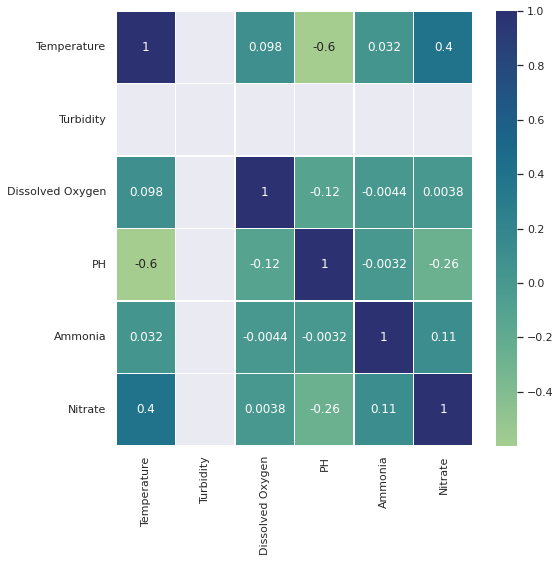

In [83]:
import seaborn as sns; sns.set()
plt.figure(figsize=(8,8))
sns.heatmap(X_train.corr(), annot=True, cmap='crest',linewidth=.5)

Temperature Predictions: 

In [130]:
# X_train = train_df.drop("Temperature",axis=1)
X_train = train_df[['Temperature','PH']]
y_train = train_df['Temperature']
# X_test = val_df.drop("Temperature",axis=1)
X_test = val_df[['Temperature','PH']]

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler on your training data
scaler.fit(X_train)

X_train_norm = scaler.transform(X_train)
X_test_norm = scaler.transform(X_test)


Preparing our Training Data sequences with label predictions

In [131]:
# we'll start out with a 2 minute input sequence and a one minute predictive horizon
seq_arrays = []
seq_labs = []
seq_length = 2
ph = 1


num_train_rows=train_df.shape[0]

#create list of sequence length Temperature readings
for start in range(0,num_train_rows-seq_length-ph):
    seq_arrays.append(X_train_norm[start:start+seq_length])
#     seq_arrays.append(train_df[feat_cols].iloc[start:start+seq_length].to_numpy())
    seq_labs.append([train_df['Temperature'].iloc[start:start+seq_length+1].to_numpy()[-1]])

seq_arrays = np.array(seq_arrays, dtype = object).astype(np.float32)
seq_labs = np.array(seq_labs, dtype = object).astype(np.float32)

In [132]:
seq_arrays.shape

(1541, 2, 2)

In [133]:
seq_labs.shape

(1541, 1)

Preparing our Test Data sequences with label predictions

In [134]:
val_arrays = []
val_labs = []

num_test_rows=val_df.shape[0]

i=1

#create list of Temperature readings starting with a minimum of two readings
for start in range(2,num_test_rows):
    incoming_df=val_df[0:start] 
    
    if len(incoming_df) > seq_length: 
        
        val_arrays.append(X_test_norm[i:i+seq_length])
        val_labs.append([incoming_df['Temperature'].iloc[i:i+seq_length+ph].to_numpy()[-1]])
        i+=1
        
    else:
        
        val_arrays.append(X_test_norm[0:len(incoming_df)])
        val_labs.append([incoming_df['Temperature'].iloc[0:len(incoming_df)+ph].to_numpy()[-1]])
        
# use the pad_sequences function on your input sequences
val_arrays = tf.keras.preprocessing.sequence.pad_sequences(val_arrays, dtype='float32', padding='post',value=val_df["Temperature"].mean())     

#convert labels to numpy arrays and floats to appease keras/tensorflow
val_labs = np.array(val_labs, dtype = object).astype(np.float32)

In [135]:
val_arrays.shape

(384, 2, 2)

In [136]:
val_labs.shape

(384, 1)



## Model Training

We will begin with a model architecture very similar to the model we built in the lab session. We will have two LSTM layers, with 5 and 3 hidden units respectively, and we will apply dropout after each LSTM layer. However, we will use a linear final layer and MSE for our loss function, since our output is continuous instead of binary.


CNN-LSTM Model

In [157]:
from keras.layers import Conv1D, BatchNormalization
model_path = 'CNN_LSTM_model1.h5'
# build the network
nb_features = seq_arrays.shape[2]
nb_out = seq_labs.shape[1]
model = Sequential()

model.add(Conv1D(32,input_shape=(seq_length, nb_features),kernel_size=2, padding="causal",activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv1D(48,kernel_size=2,padding="causal",activation="relu",dilation_rate=2))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv1D(64,kernel_size=2,padding="causal",activation="relu",dilation_rate=4))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(LSTM(50))
model.add(Dropout(0.2))

model.add(Dense(units = nb_out))
model.add(Activation("linear"))
optimizer = keras.optimizers.Adam(learning_rate = 0.001)
model.compile(loss='mean_squared_error', optimizer=optimizer,metrics=['mse'])
print(model.summary())

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_41 (Conv1D)          (None, 2, 32)             160       
                                                                 
 batch_normalization_41 (Bat  (None, 2, 32)            128       
 chNormalization)                                                
                                                                 
 dropout_50 (Dropout)        (None, 2, 32)             0         
                                                                 
 conv1d_42 (Conv1D)          (None, 2, 48)             3120      
                                                                 
 batch_normalization_42 (Bat  (None, 2, 48)            192       
 chNormalization)                                                
                                                                 
 dropout_51 (Dropout)        (None, 2, 48)           

In [138]:
history = model.fit(seq_arrays, seq_labs, epochs=100, batch_size=50,validation_split=0.05, verbose=2,
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0, patience=10, verbose=0, mode='min'),
keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True,mode='min', verbose=0)])
# list all data in history
print(history.history.keys())

Epoch 1/100
30/30 - 2s - loss: 611.4265 - mse: 611.4265 - val_loss: 646.8666 - val_mse: 646.8666 - 2s/epoch - 74ms/step
Epoch 2/100
30/30 - 0s - loss: 494.8802 - mse: 494.8802 - val_loss: 566.5978 - val_mse: 566.5978 - 122ms/epoch - 4ms/step
Epoch 3/100
30/30 - 0s - loss: 384.3030 - mse: 384.3030 - val_loss: 409.6381 - val_mse: 409.6381 - 122ms/epoch - 4ms/step
Epoch 4/100
30/30 - 0s - loss: 296.9779 - mse: 296.9779 - val_loss: 284.0610 - val_mse: 284.0610 - 121ms/epoch - 4ms/step
Epoch 5/100
30/30 - 0s - loss: 229.0175 - mse: 229.0175 - val_loss: 202.1991 - val_mse: 202.1991 - 123ms/epoch - 4ms/step
Epoch 6/100
30/30 - 0s - loss: 146.2021 - mse: 146.2021 - val_loss: 137.3414 - val_mse: 137.3414 - 130ms/epoch - 4ms/step
Epoch 7/100
30/30 - 0s - loss: 95.2936 - mse: 95.2936 - val_loss: 96.9183 - val_mse: 96.9183 - 122ms/epoch - 4ms/step
Epoch 8/100
30/30 - 0s - loss: 69.8521 - mse: 69.8521 - val_loss: 74.3255 - val_mse: 74.3255 - 127ms/epoch - 4ms/step
Epoch 9/100
30/30 - 0s - loss: 51.

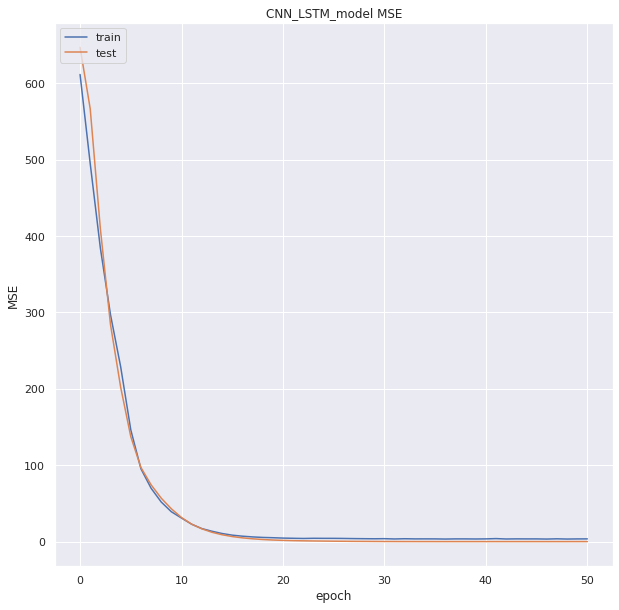

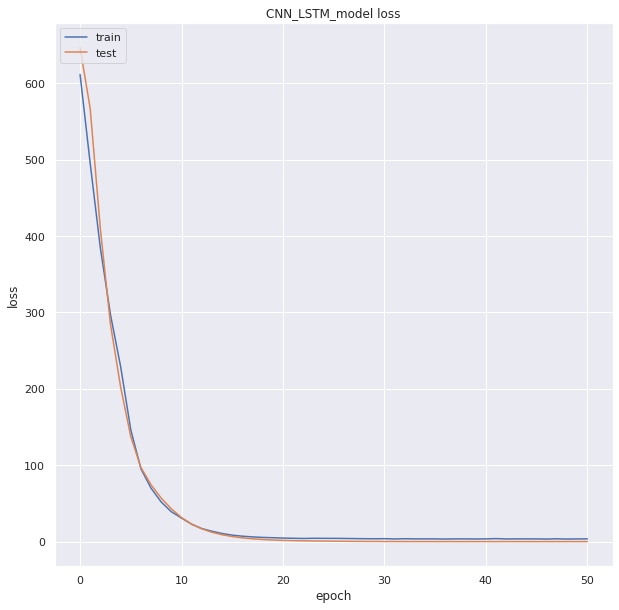

In [139]:
# summarize history for MSE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('CNN_LSTM_model MSE')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("CNN_LSTM_mse1.png")

# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('CNN_LSTM_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("CNN_LSTM_loss1.png")


We will now run this validation data through our CNN-LSTM model and visualize its performance 

12/12 - 0s - loss: 0.1466 - mse: 0.1466 - 26ms/epoch - 2ms/step

MSE: 0.14662422239780426
12/12 [==============================] - 0s 1ms/step


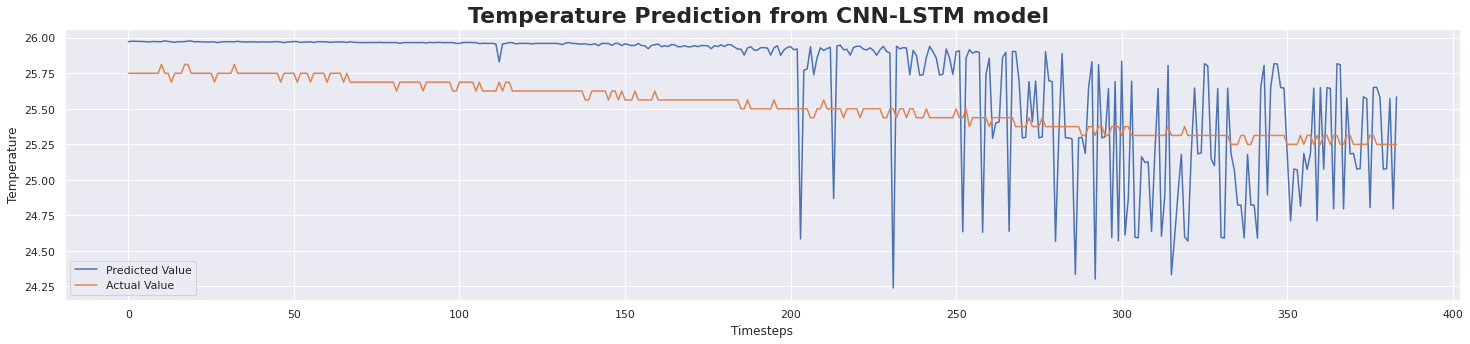

In [141]:
scores_test = model.evaluate(val_arrays, val_labs, verbose=2)
print('\nMSE: {}'.format(scores_test[1]))

y_pred_test = model.predict(val_arrays)
y_true_test = val_labs

test_set = pd.DataFrame(y_pred_test)
test_set.to_csv('Temperature_predictions.csv', index = None)

# Plot the predicted data vs. the actual data
# we will limit our plot to the first 200 predictions for better visualization
fig_verify = plt.figure(figsize=(25, 5))
# plt.plot(y_pred_test[-100:], label = 'Predicted Value')
# plt.plot(y_true_test[-100:], label = 'Actual Value')
plt.plot(y_pred_test, label = 'Predicted Value')
plt.plot(y_true_test, label = 'Actual Value')
plt.title('Temperature Prediction from CNN-LSTM model ', fontsize=22, fontweight='bold')
plt.ylabel('Temperature')
plt.xlabel('Timesteps')
plt.legend()
plt.show()
fig_verify.savefig("Temperature_Predictions.png")

pH Predictions

In [150]:
# X_train = train_df.drop("Temperature",axis=1)
X_train = train_df[['Temperature','PH']]
y_train = train_df['PH']
# X_test = val_df.drop("Temperature",axis=1)
X_test = val_df[['Temperature','PH']]

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler on your training data
scaler.fit(X_train)

X_train_norm = scaler.transform(X_train)
X_test_norm = scaler.transform(X_test)

In [151]:
# we'll start out with a 2 minute input sequence and a one minute predictive horizon
seq_arrays = []
seq_labs = []
seq_length = 2
ph = 1


num_train_rows=train_df.shape[0]

#create list of sequence length Temperature readings
for start in range(0,num_train_rows-seq_length-ph):
    seq_arrays.append(X_train_norm[start:start+seq_length])
#     seq_arrays.append(train_df[feat_cols].iloc[start:start+seq_length].to_numpy())
    seq_labs.append([train_df['PH'].iloc[start:start+seq_length+1].to_numpy()[-1]])

seq_arrays = np.array(seq_arrays, dtype = object).astype(np.float32)
seq_labs = np.array(seq_labs, dtype = object).astype(np.float32)

In [152]:
val_arrays = []
val_labs = []

num_test_rows=val_df.shape[0]

i=1

#create list of Temperature readings starting with a minimum of two readings
for start in range(2,num_test_rows):
    incoming_df=val_df[0:start] 
    
    if len(incoming_df) > seq_length: 
        
        val_arrays.append(X_test_norm[i:i+seq_length])
        val_labs.append([incoming_df['PH'].iloc[i:i+seq_length+ph].to_numpy()[-1]])
        i+=1
        
    else:
        
        val_arrays.append(X_test_norm[0:len(incoming_df)])
        val_labs.append([incoming_df['PH'].iloc[0:len(incoming_df)+ph].to_numpy()[-1]])
        
# use the pad_sequences function on your input sequences
val_arrays = tf.keras.preprocessing.sequence.pad_sequences(val_arrays, dtype='float32', padding='post',value=val_df["PH"].mean())     

#convert labels to numpy arrays and floats to appease keras/tensorflow
val_labs = np.array(val_labs, dtype = object).astype(np.float32)

In [156]:
print(val_arrays.shape,val_labs.shape,seq_arrays.shape,seq_labs.shape)

(384, 2, 2) (384, 1) (1541, 2, 2) (1541, 1)


In [ ]:
from keras.layers import Conv1D, BatchNormalization
model_path = 'CNN_LSTM_model1.h5'
# build the network
nb_features = seq_arrays.shape[2]
nb_out = seq_labs.shape[1]
model = Sequential()

model.add(Conv1D(32,input_shape=(seq_length, nb_features),kernel_size=2, padding="causal",activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv1D(48,kernel_size=2,padding="causal",activation="relu",dilation_rate=2))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv1D(64,kernel_size=2,padding="causal",activation="relu",dilation_rate=4))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(LSTM(50))
model.add(Dropout(0.2))

model.add(Dense(units = nb_out))
model.add(Activation("linear"))
optimizer = keras.optimizers.Adam(learning_rate = 0.001)
model.compile(loss='mean_squared_error', optimizer=optimizer,metrics=['mse'])
print(model.summary())

In [158]:
history = model.fit(seq_arrays, seq_labs, epochs=100, batch_size=50,validation_split=0.05, verbose=2,
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0, patience=10, verbose=0, mode='min'),
keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True,mode='min', verbose=0)])
# list all data in history
print(history.history.keys())

Epoch 1/100
30/30 - 2s - loss: 61.8025 - mse: 61.8025 - val_loss: 65.4554 - val_mse: 65.4554 - 2s/epoch - 77ms/step
Epoch 2/100
30/30 - 0s - loss: 30.8355 - mse: 30.8355 - val_loss: 53.6749 - val_mse: 53.6749 - 123ms/epoch - 4ms/step
Epoch 3/100
30/30 - 0s - loss: 8.0011 - mse: 8.0011 - val_loss: 36.3219 - val_mse: 36.3219 - 125ms/epoch - 4ms/step
Epoch 4/100
30/30 - 0s - loss: 1.7287 - mse: 1.7287 - val_loss: 22.3589 - val_mse: 22.3589 - 123ms/epoch - 4ms/step
Epoch 5/100
30/30 - 0s - loss: 0.7287 - mse: 0.7287 - val_loss: 14.9541 - val_mse: 14.9541 - 125ms/epoch - 4ms/step
Epoch 6/100
30/30 - 0s - loss: 0.6367 - mse: 0.6367 - val_loss: 10.4915 - val_mse: 10.4915 - 126ms/epoch - 4ms/step
Epoch 7/100
30/30 - 0s - loss: 0.6069 - mse: 0.6069 - val_loss: 7.3640 - val_mse: 7.3640 - 124ms/epoch - 4ms/step
Epoch 8/100
30/30 - 0s - loss: 0.6092 - mse: 0.6092 - val_loss: 4.9155 - val_mse: 4.9155 - 129ms/epoch - 4ms/step
Epoch 9/100
30/30 - 0s - loss: 0.6188 - mse: 0.6188 - val_loss: 3.0914 - v

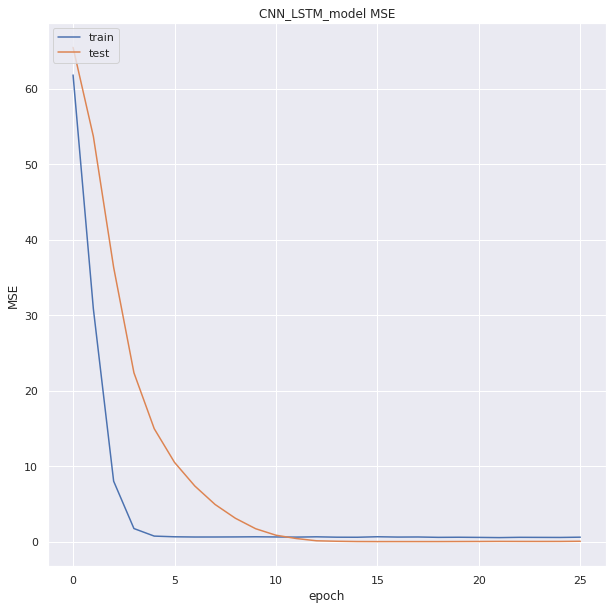

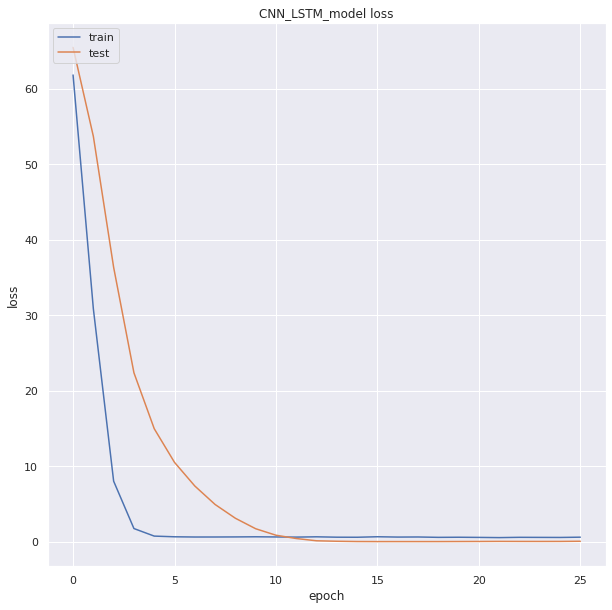

In [159]:
# summarize history for MSE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('CNN_LSTM_model MSE')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("CNN_LSTM_mse1.png")

# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('CNN_LSTM_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("CNN_LSTM_loss1.png")


12/12 - 0s - loss: 0.0333 - mse: 0.0333 - 28ms/epoch - 2ms/step

MSE: 0.03329513594508171
12/12 [==============================] - 0s 1ms/step


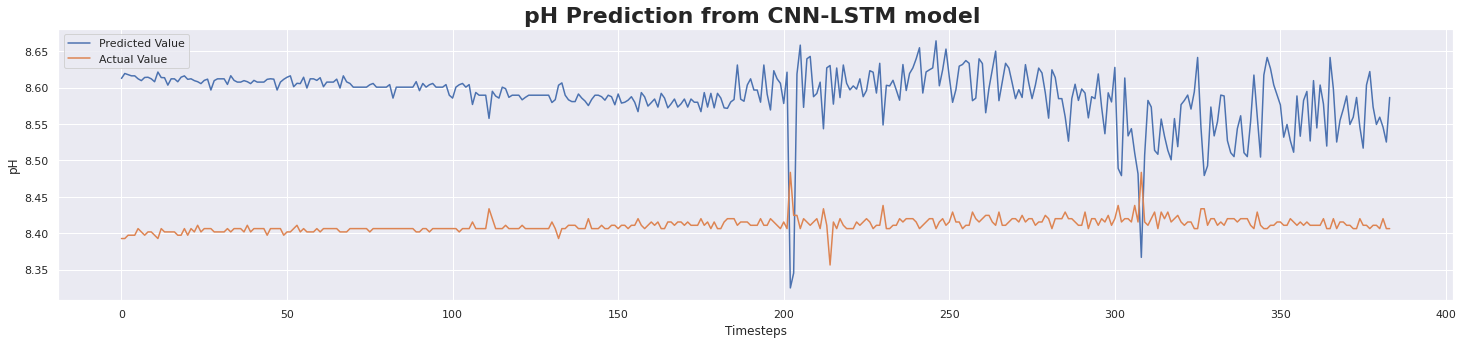

In [160]:
scores_test = model.evaluate(val_arrays, val_labs, verbose=2)
print('\nMSE: {}'.format(scores_test[1]))

y_pred_test = model.predict(val_arrays)
y_true_test = val_labs

test_set = pd.DataFrame(y_pred_test)
test_set.to_csv('pH_predictions.csv', index = None)

# Plot the predicted data vs. the actual data
# we will limit our plot to the first 200 predictions for better visualization
fig_verify = plt.figure(figsize=(25, 5))
# plt.plot(y_pred_test[-100:], label = 'Predicted Value')
# plt.plot(y_true_test[-100:], label = 'Actual Value')
plt.plot(y_pred_test, label = 'Predicted Value')
plt.plot(y_true_test, label = 'Actual Value')
plt.title('pH Prediction from CNN-LSTM model ', fontsize=22, fontweight='bold')
plt.ylabel('pH')
plt.xlabel('Timesteps')
plt.legend()
plt.show()
fig_verify.savefig("pH_Predictions.png")

Turbidity Predictions